## 特征工程之特征选择（三）
### 3. Embedded
#### 3.1 基于L1正则（惩罚项）的特征选择<br>
有过一点机器学习基础的同学都知道，将L1正则放置于cost function中，会起到特征选择的作用，它会使某些系数变为0,<br>
从而得到稀疏解，也起到一个降维的作用。<br>

In [1]:
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel  # 使用SelectFromModel库来进行特征选择

In [2]:
# 导入数据
iris = load_iris()
X, y = iris.data, iris.target

In [3]:
# 查看数据的维度，可知道是一个有4维特征的数据
X.shape

(150, 4)

In [4]:
# 指定为l1正则项， C为惩罚系数，用来控制稀疏的程度，即在L1前面的系数，即alpha值，较小的C会导致少的特征被选择
lsvc = LinearSVC(penalty='l1', C=0.01, dual=False)  
lsvc.fit(X, y)
model = SelectFromModel(estimator=lsvc, prefit=True)# prefit=True,表示可使用训练的模型之后必须调用transform进行特征选择
X_new = model.transform(X)   # 进行特征选择
# 可以看出，移除掉了一个特征
X_new.shape

(150, 3)

### 下面是scikit-learn的一个详细示例
使用SelectFromModel和Lasso在Boston数据集中选择最好的特征

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [6]:
# 导入数据
boston = load_boston()
X, y = boston.data, boston.target

In [7]:
X.shape, y.shape

((506, 13), (506,))

In [8]:
# 观察数据可知道，这是一个需要用回归模型的数据，所以我们用到了LassoCV
X[:10], y[:10]

(array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
         6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
         1.5300e+01, 3.9690e+02, 4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9690e+02, 9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9283e+02, 4.0300e+00],
        [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
         6.9980e+00, 4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
         1.8700e+01, 3.9463e+02, 2.9400e+00],
        [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
         7.1470e+00, 5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
         1.8700e+01, 3.9690e+02, 5.3300e+00],
        [2.9850e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
         6.

In [9]:
# 创建基础模型， 有同学会问道Lasso和LassoCV的区别，
# 区别就是后面的CV(Cross validation)一个用到交叉验证，一个没有
clf = LassoCV()

# 这里就使用到了一个参数为threshold(阈值)，即选择重要性大于该阈值的特征，其余的移除
sfm = SelectFromModel(estimator=clf, threshold=0.25)
sfm.fit(X, y)

# 进行特征选择，且返回筛选过后的特征维度,从结果来看，只剩下了5个特征(原本为13)
n_features = sfm.transform(X).shape[1]
n_features

5

In [10]:
# 在这里，我们的目标是一直将模型训练，知道特征只剩两个
# 当前，我们需要一直增大threshold的强度，才能筛选出更少的特征
while n_features > 2 :
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

In [11]:
n_features

2

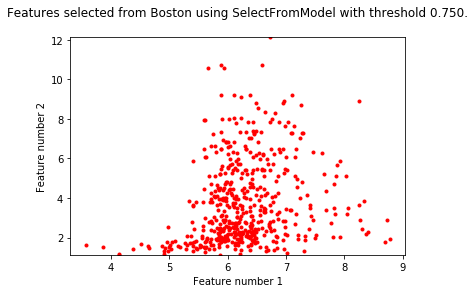

In [12]:
# 画出特征
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f.\n" % sfm.threshold)
feature_1 = X_transform[:, 0]
feature_2 = X_transform[:, 1]
plt.plot(feature_1, feature_2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature_2), np.max(feature_2)])
plt.show()

### 在这里强调一句，正则项的alpha数值不能随便乱选的，最好是通过交叉验证(LassoCV或LassoLarsCV)来寻找更优的alpha系数。

#### 3.2 基于Tree(树)模型的特征选择
基于树的基类模型（有单树型sklearn.tree，也有树的森林sklearn.ensemble）可以用来计算特征的重要性，然后消除不相关的特征。

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

In [14]:
lris = load_iris()
X, y = lris.data, lris.target
X.shape

(150, 4)

In [15]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
# 查看特征重要性,可见后两个特征更为重要
clf.feature_importances_

array([0.12605878, 0.0376242 , 0.52565363, 0.31066339])

In [16]:
model = SelectFromModel(estimator=clf, prefit=True)
X_new = model.transform(X)
X_new.shape

(150, 2)

### 在人脸识别上的示例

In [17]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

In [18]:
# 导入数据,这个会自动从网上下载
data = fetch_olivetti_faces()
X_faces = data.images
y = data.target

由数据集的shape可以看出，没个人脸图像是一个64*64的图像，且有40类，每类10个样本

In [19]:
X_faces.shape, len(set(y))

((400, 64, 64), 40)

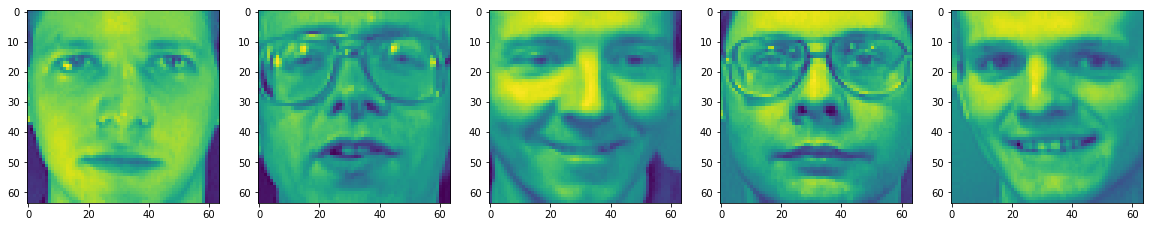

In [20]:
# 我们取出前五类出来进行分析
plt.figure(figsize=(20, 20)) 
for i in range(5): 
    plt.subplot(1,5, i+1)
    plt.imshow(X_faces[i*10])
plt.show()

In [21]:
X = X_faces[0:50].reshape(len(X_faces[0:50]), -1)  # reshape成一维
y = y[0:50]
X.shape, y.shape

((50, 4096), (50,))

In [22]:
%%time
# 创建一个带有1000棵树的森林
# 线程
n_jobs = 1
# 最佳分割时所要考虑的特征数量为128
forest = ExtraTreesClassifier(n_estimators=1000, max_features=128, n_jobs=n_jobs, random_state=0)
forest.fit(X, y)

Wall time: 1.44 s


In [23]:
importances = forest.feature_importances_
print(importances[:10])   # 输出前10个特征来看看
print(importances.shape)
importances = importances.reshape(X_faces[0].shape)
print(importances.shape)

[6.25000000e-05 0.00000000e+00 1.91186869e-04 8.33333333e-05
 1.16111111e-04 9.88636364e-05 0.00000000e+00 0.00000000e+00
 4.54545455e-05 0.00000000e+00]
(4096,)
(64, 64)


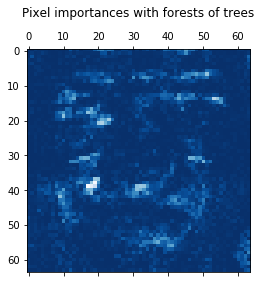

In [24]:
# 画出像素重要性图案
plt.matshow(importances, cmap=plt.cm.Blues_r)
plt.title("Pixel importances with forests of trees\n")
plt.show()

### 由上图可以看出，比较重要的特征都集中在人脸的五官的位置，人脸外的特征都不那么重要。